# Import statements
Following packages are necessary:

In [1]:
import sys
sys.path.append("D:\Julian\workspace\endolas\packages")

import random
from endolas import utils
import os
import imageio
import json
from endolas  import closs
from endolas import ccall

from endolas import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from endolas import UNet
from endolas import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 8.1) Supervised Euclidean for LASTEN2
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
tf.keras.backend.clear_session()

store_path = '../results/8_1_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/test'

path_fixed = r'D:\Julian\data\LASTEN2\fix'
path_train = r'D:\Julian\data\LASTEN2\train'
path_validation = r'D:\Julian\data\LASTEN2\validation'
path_test = r'D:\Julian\data\LASTEN2\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [8]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 10 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

40/40 [==============================] - 21s 532ms/step - loss: 1453.1646 - maed: 32.4918 - val_loss: 1409.1478 - val_maed: 32.7858
Epoch 2/100
40/40 [==============================] - 9s 213ms/step - loss: 595.3770 - maed: 20.2003 - val_loss: 2025.8948 - val_maed: 36.9519
Epoch 3/100
40/40 [==============================] - 9s 233ms/step - loss: 372.9528 - maed: 15.6808 - val_loss: 2464.7727 - val_maed: 42.4350
Epoch 4/100
40/40 [==============================] - 10s 252ms/step - loss: 250.2986 - maed: 12.5849 - val_loss: 1080.2444 - val_maed: 28.0918
Epoch 5/100
40/40 [==============================] - 9s 227ms/step - loss: 229.7769 - maed: 12.5432 - val_loss: 845.1992 - val_maed: 24.9085
Epoch 6/100
40/40 [==============================] - 9s 232ms/step - loss: 134.1811 - maed: 9.6468 - val_loss: 802.1434 - val_maed: 24.2619
Epoch 7/100
40/40 [==============================] - 9s 237ms/step - loss: 118.3522 - maed: 8.9985 - val_loss: 742.3489 - val_maed: 23.0614
Epoch 8/100
40/40 [=

KeyError: 'val_loss'

# Evaluation
Evaluate the trained network

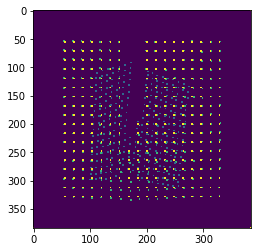

In [14]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 8.3) Supervised Euclidean for LASTEN2_25
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
tf.keras.backend.clear_session()

store_path = '../results/8_3_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_25/test'

path_fixed = r'D:\Julian\data\LASTEN2_25\fix'
path_train = r'D:\Julian\data\LASTEN2_25\train'
path_validation = r'D:\Julian\data\LASTEN2_25\validation'
path_test = r'D:\Julian\data\LASTEN2_25\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [8]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 80 steps, validate for 10 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

80/80 [==============================] - 28s 350ms/step - loss: 2171.3343 - maed: 38.6067 - val_loss: 30018.9301 - val_maed: 157.9508
Epoch 2/100
80/80 [==============================] - 15s 183ms/step - loss: 1381.6154 - maed: 29.9363 - val_loss: 7111.6505 - val_maed: 67.6354
Epoch 3/100
80/80 [==============================] - 15s 186ms/step - loss: 1168.3024 - maed: 27.2363 - val_loss: 6412.1721 - val_maed: 73.9876
Epoch 4/100
80/80 [==============================] - 14s 175ms/step - loss: 965.0819 - maed: 24.5727 - val_loss: 2036.1176 - val_maed: 36.9789
Epoch 5/100
80/80 [==============================] - 14s 179ms/step - loss: 919.6243 - maed: 23.9977 - val_loss: 2099.8702 - val_maed: 41.1208
Epoch 6/100
80/80 [==============================] - 14s 173ms/step - loss: 743.3043 - maed: 21.3720 - val_loss: 780.4246 - val_maed: 23.3801
Epoch 7/100
80/80 [==============================] - 13s 159ms/step - loss: 650.4991 - maed: 20.0072 - val_loss: 2812.8398 - val_maed: 48.1648
Epoch 8

# Evaluation
Evaluate the trained network

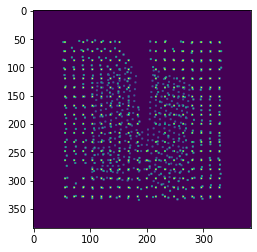

In [9]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 8.4) Supervised Euclidean for LASTEN2_50
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [10]:
tf.keras.backend.clear_session()

store_path = '../results/8_4_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2_50/test'

path_fixed = r'D:\Julian\data\LASTEN2_50\fix'
path_train = r'D:\Julian\data\LASTEN2_50\train'
path_validation = r'D:\Julian\data\LASTEN2_50\validation'
path_test = r'D:\Julian\data\LASTEN2_50\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [11]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [12]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [13]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [14]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 80 steps, validate for 10 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

80/80 [==============================] - 24s 295ms/step - loss: 2071.1192 - maed: 38.2495 - val_loss: 121211.5000 - val_maed: 302.8569
Epoch 2/100
80/80 [==============================] - 16s 202ms/step - loss: 1309.2786 - maed: 29.0262 - val_loss: 26972.5172 - val_maed: 128.2192
Epoch 3/100
80/80 [==============================] - 16s 200ms/step - loss: 943.8048 - maed: 24.0710 - val_loss: 16349.4615 - val_maed: 111.6780
Epoch 4/100
80/80 [==============================] - 18s 220ms/step - loss: 831.6401 - maed: 22.5180 - val_loss: 1014.7472 - val_maed: 28.2807
Epoch 5/100
80/80 [==============================] - 16s 202ms/step - loss: 737.2461 - maed: 21.1157 - val_loss: 1735.3029 - val_maed: 35.9202
Epoch 6/100
80/80 [==============================] - 15s 193ms/step - loss: 606.4652 - maed: 18.9135 - val_loss: 1166.2818 - val_maed: 30.5802
Epoch 7/100
80/80 [==============================] - 16s 205ms/step - loss: 539.2705 - maed: 17.8418 - val_loss: 458.3213 - val_maed: 18.7441
Epo

# Evaluation
Evaluate the trained network

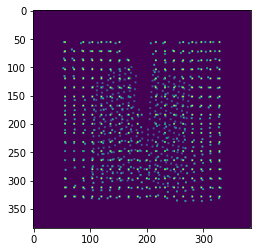

In [15]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)